# `CNStateModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+6.ge3576a9.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]
Upper state quantum numbers: ['1 0 1 1', '1 0 

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

12CN-1 550
12CN-2 300
Transition 113144.19 is constraining upper state 1 from lower state 1
Transition 113191.325 is constraining upper state 3 from lower state 1
Transition 113490.985 is constraining upper state 0 from lower state 1
Transition 113508.934 is constraining upper state 4 from lower state 1
Transition 113520.4215 is constraining upper state 2 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 1
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 1

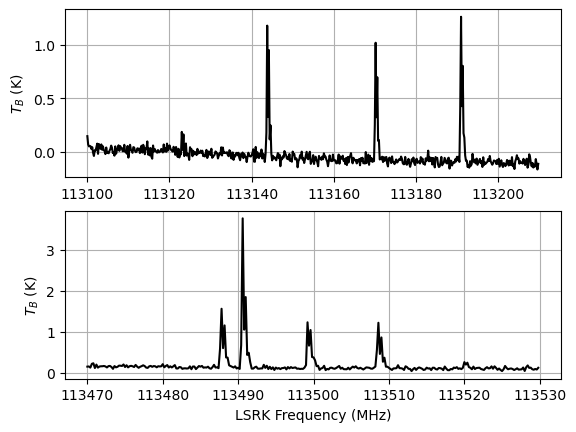

In [3]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = mean cloud excitation temperature
    prior_boltz_factor_sigma = 0.0, # width of hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0": [13.5, 13.2, 12.8],
    "log10_Tkin": [0.5, 0.7, 1.2],
    "fwhm_nonthermal": [0.5, 0.2, 0.4],
    "velocity": [-1.0, 0.0, 1.0],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau = model.model.tau.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
log10_Nl = model.model.log10_Nl.eval(sim_params, on_unused_input="ignore")
log10_Nu = model.model.log10_Nu.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}


print()
print("Tex:")
print(Tex)

print()
print("tau:")
print(tau)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

12CN-1 550
12CN-2 300

Tex:
[[ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227853  5.01187372 15.84893631]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227848  5.01187363 15.84893602]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227885  5.01187423 15.8489379 ]
 [ 3.16227766  5.01187234 15.84893192]
 [ 3.16227766  5.01187234 15.84893192]]

tau:
[[0.04600827 0.01859568 0.0032464 ]
 [0.37663661 0.15221672 0.02657146]
 [0.36781083 0.1486733  0.02595816]
 [0.47765161 0.19305602 0.0337045 ]
 [0.47926426 0.19382097 0.03386788]
 [1.27322207 0.51485055 0.08995233]
 [0.37813589 0.15292604 0.02672276]
 [0.36945523 0.14940018 0.02610369]
 [0.04622051 0.01869097 0.00326584]]

tau_total:
[3.81440528 1.54223043 0.26939303]

log10_N:
[13.862653   13.67989297 13.47137344]


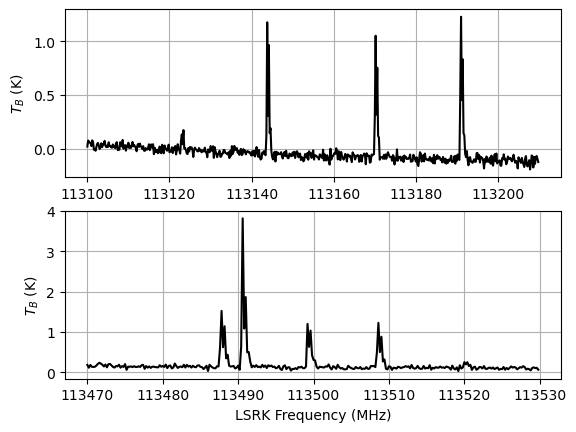

In [4]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_state_model import CNStateModel

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNStateModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_Nu": log10_Nu,
    "log10_Nl": log10_Nl,
    "log10_Tkin": [0.5, 0.7, 1.2],
    "fwhm_nonthermal": [0.5, 0.2, 0.4],
    "velocity": [-1.0, 0.0, 1.0],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau = model.model.tau.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau:")
print(tau)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

12CN-1 550
12CN-2 300


## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [7]:
# Initialize and define the model
model = CNStateModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

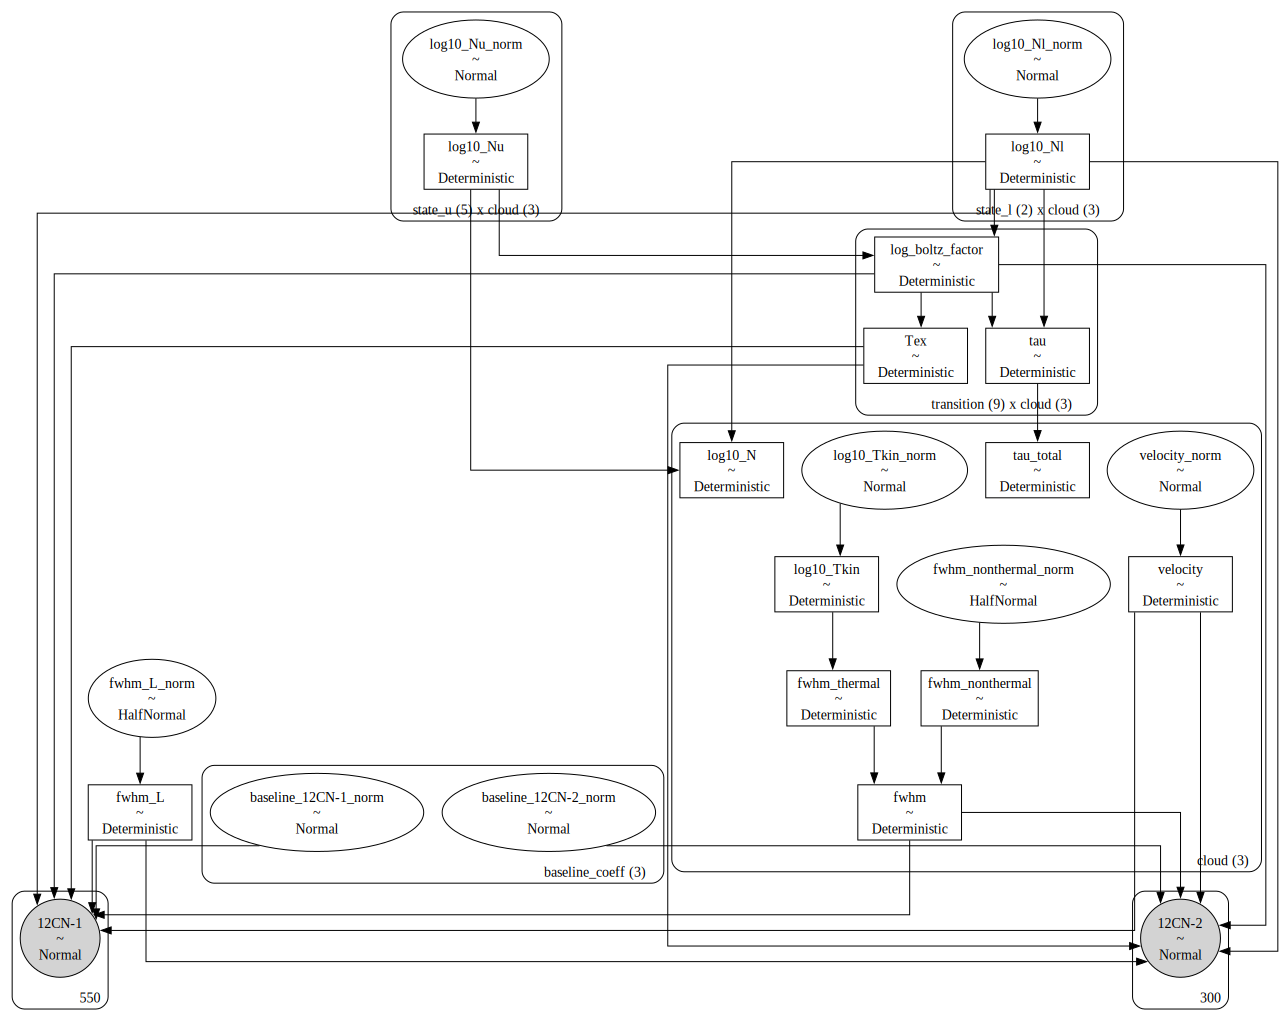

In [8]:
# Plot model graph
model.graph().render('cn_state_model', format='png')
model.graph()

In [9]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, <constant>)
baseline_12CN-2_norm ~ Normal(0, <constant>)
       log10_Nl_norm ~ Normal(0, 1)
       log10_Nu_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
       velocity_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
         fwhm_L_norm ~ HalfNormal(0, 1)
            log10_Nl ~ Deterministic(f(log10_Nl_norm))
            log10_Nu ~ Deterministic(f(log10_Nu_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
    log_boltz_factor ~ Deterministic(f(log10_Nl_norm, log10_Nu_norm))
                 Tex ~ Deterministic(f(log10_Nl_norm, log10_Nu_norm))
             log10_N ~ Deterministic(f(log10_Nu_norm, log10_Nl_norm))
            velocity ~ Deterministic(f(velocity_norm))
        fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
              fwhm_L ~ Deterministic(f(fwhm_L_norm))
   

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

ValueError: Model initial point is not finite! Mis-specified model or bad priors?

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 2,230.3


Output()

Runtime: 0.65 minutes


In [11]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log10_N0[0]              13.207  0.008  13.194   13.223      0.000    0.000   
log10_N0[1]              12.772  0.003  12.766   12.778      0.000    0.000   
log10_N0[2]              13.292  0.026  13.240   13.338      0.001    0.001   
log10_Tkin[0]             0.699  0.003   0.695    0.705      0.000    0.000   
log10_Tkin[1]             1.260  0.007   1.248    1.273      0.000    0.000   
log10_Tkin[2]             0.516  0.004   0.510    0.523      0.000    0.000   
log10_Tex_mean[0]         0.699  0.003   0.695    0.705      0.000    0.000   
log10_Tex_mean[1]         1.260  0.007   1.248    1.273      0.000    0.000   
log10_Tex_mean[2]         0.516  0.004   0.510    0.523      0.000    0.000   
log10_N[0]               13.687  0.008  13.674   13.704      0.000    0.000   
log10_N[1]               13.456  0.004  13.449   13.462      0.000    0.000   
log10_N[2]               13.664  0.026  13.612   13.711      0.001    0.001   
velocity[0]               0.018  0.004   0.010    0.025      0.000    0.000   
velocity[1]               0.992  0.004   0.986    1.000      0.000    0.000   
velocity[2]              -1.020  0.017  -1.050   -0.987      0.001    0.000   
fwhm_thermal[0]           0.094  0.000   0.093    0.094      0.000    0.000   
fwhm_thermal[1]           0.179  0.001   0.177    0.182      0.000    0.000   
fwhm_thermal[2]           0.076  0.000   0.075    0.077      0.000    0.000   
fwhm_nonthermal[0]        0.096  0.052   0.023    0.197      0.002    0.001   
fwhm_nonthermal[1]        0.401  0.008   0.385    0.415      0.000    0.000   
fwhm_nonthermal[2]        0.488  0.051   0.401    0.593      0.002    0.001   
fwhm[0]                   0.139  0.040   0.096    0.217      0.001    0.001   
fwhm[1]                   0.439  0.007   0.424    0.452      0.000    0.000   
fwhm[2]                   0.494  0.051   0.409    0.598      0.002    0.001   
tau_total[0]              1.570  0.029   1.518    1.623      0.001    0.001   
tau_total[1]              0.224  0.003   0.218    0.230      0.000    0.000   
tau_total[2]              2.333  0.139   2.061    2.583      0.004    0.003   
fwhm_L                    0.019  0.006   0.010    0.030      0.000    0.000   
baseline_12CN-1_norm[0]  -0.127  0.043  -0.207   -0.049      0.001    0.001   
baseline_12CN-1_norm[1]  -4.792  0.162  -5.073   -4.481      0.005    0.004   
baseline_12CN-1_norm[2]   2.603  0.723   1.314    4.008      0.023    0.016   
baseline_12CN-2_norm[0]  -0.237  0.059  -0.333   -0.111      0.002    0.001   
baseline_12CN-2_norm[1]  -2.096  0.229  -2.503   -1.657      0.008    0.006   
baseline_12CN-2_norm[2]   1.504  0.823   0.128    3.138      0.026    0.018   

                         ess_bulk  ess_tail  r_hat  
log10_N0[0]                 767.0     775.0    NaN  
log10_N0[1]                1130.0     880.0    NaN  
log10_N0[2]                1015.0     908.0    NaN  
log10_Tkin[0]               978.0     795.0    NaN  
log10_Tkin[1]               938.0     820.0    NaN  
log10_Tkin[2]              1004.0     786.0    NaN  
log10_Tex_mean[0]           978.0     795.0    NaN  
log10_Tex_mean[1]           938.0     820.0    NaN  
log10_Tex_mean[2]          1004.0     786.0    NaN  
log10_N[0]                  744.0     874.0    NaN  
log10_N[1]                 1016.0     863.0    NaN  
log10_N[2]                  993.0     840.0    NaN  
velocity[0]                 975.0     889.0    NaN  
velocity[1]                 807.0    1024.0    NaN  
velocity[2]                 991.0     788.0    NaN  
fwhm_thermal[0]             978.0     795.0    NaN  
fwhm_thermal[1]             938.0     820.0    NaN  
fwhm_thermal[2]            1004.0     786.0    NaN  
fwhm_nonthermal[0]         1008.0     779.0    NaN  
fwhm_nonthermal[1]         1038.0    1026.0    NaN  
fwhm_nonthermal[2]          969.0    1033.0    NaN  
fwhm[0]                    1013.0     779.0    NaN  
fwhm[1]                    1041.0    1026.

Sampling: [12CN-1, 12CN-2]


Output()

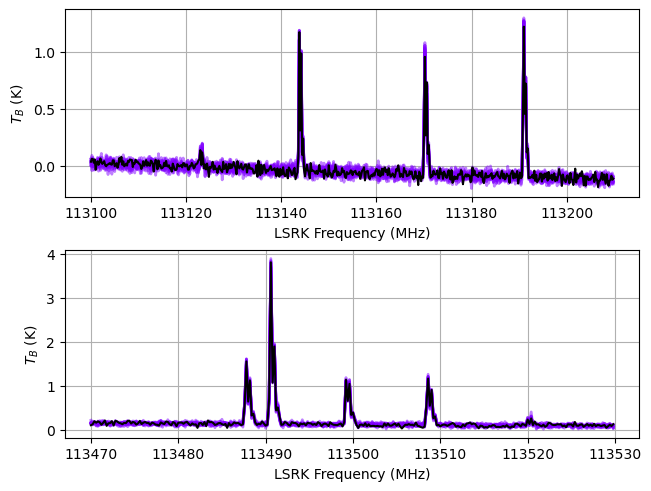

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 2,230.3
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, log10_N0_norm, log10_Tkin_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 291 seconds.


Adding log-likelihood to trace


Output()

There were 33 divergences in converged chains.
Runtime: 5.86 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log10_N0[0]              13.200  0.017  13.170   13.232      0.000    0.000   
log10_N0[1]              12.756  0.022  12.713   12.797      0.000    0.000   
log10_N0[2]              13.383  0.068  13.251   13.508      0.001    0.001   
log10_Tkin[0]             0.699  0.005   0.690    0.708      0.000    0.000   
log10_Tkin[1]             1.292  0.054   1.197    1.400      0.001    0.001   
log10_Tkin[2]             0.508  0.006   0.497    0.520      0.000    0.000   
log10_Tex_mean[0]         0.699  0.005   0.690    0.708      0.000    0.000   
log10_Tex_mean[1]         1.292  0.054   1.197    1.400      0.001    0.001   
log10_Tex_mean[2]         0.508  0.006   0.497    0.520      0.000    0.000   
log10_N[0]               13.680  0.014  13.653   13.706      0.000    0.000   
log10_N[1]               13.446  0.012  13.423   13.470      0.000    0.000   
log10_N[2]               13.750  0.065  13.626   13.869      0.001    0.001   
velocity[0]               0.010  0.005   0.002    0.019      0.000    0.000   
velocity[1]               1.000  0.004   0.993    1.008      0.000    0.000   
velocity[2]              -1.040  0.017  -1.072   -1.008      0.000    0.000   
fwhm_thermal[0]           0.094  0.001   0.093    0.095      0.000    0.000   
fwhm_thermal[1]           0.186  0.012   0.165    0.208      0.000    0.000   
fwhm_thermal[2]           0.075  0.001   0.074    0.076      0.000    0.000   
fwhm_nonthermal[0]        0.130  0.049   0.030    0.213      0.001    0.001   
fwhm_nonthermal[1]        0.402  0.012   0.381    0.423      0.000    0.000   
fwhm_nonthermal[2]        0.467  0.058   0.351    0.570      0.001    0.001   
fwhm[0]                   0.163  0.036   0.093    0.218      0.001    0.000   
fwhm[1]                   0.443  0.012   0.420    0.465      0.000    0.000   
fwhm[2]                   0.473  0.057   0.359    0.575      0.001    0.001   
tau_total[0]              1.547  0.068   1.424    1.677      0.001    0.001   
tau_total[1]              0.206  0.032   0.144    0.263      0.001    0.000   
tau_total[2]              2.928  0.483   2.093    3.862      0.006    0.004   
fwhm_L                    0.009  0.009   0.000    0.025      0.000    0.000   
baseline_12CN-1_norm[0]  -0.130  0.052  -0.230   -0.040      0.001    0.000   
baseline_12CN-1_norm[1]  -4.791  0.147  -5.069   -4.518      0.002    0.001   
baseline_12CN-1_norm[2]   2.604  0.776   1.151    4.074      0.010    0.007   
baseline_12CN-2_norm[0]  -0.230  0.070  -0.360   -0.099      0.001    0.001   
baseline_12CN-2_norm[1]  -2.115  0.197  -2.481   -1.734      0.002    0.001   
baseline_12CN-2_norm[2]   1.518  0.891  -0.134    3.223      0.010    0.007   

                         ess_bulk  ess_tail  r_hat  
log10_N0[0]                3755.0    3267.0    1.0  
log10_N0[1]                4096.0    2836.0    1.0  
log10_N0[2]                6155.0    5678.0    1.0  
log10_Tkin[0]              4347.0    4637.0    1.0  
log10_Tkin[1]              4008.0    2831.0    1.0  
log10_Tkin[2]              5734.0    5594.0    1.0  
log10_Tex_mean[0]          4347.0    4637.0    1.0  
log10_Tex_mean[1]          4008.0    2831.0    1.0  
log10_Tex_mean[2]          5734.0    5594.0    1.0  
log10_N[0]                 3819.0    3327.0    1.0  
log10_N[1]                 4321.0    2673.0    1.0  
log10_N[2]                 6201.0    5698.0    1.0  
velocity[0]                7788.0    5815.0    1.0  
velocity[1]                5492.0    4735.0    1.0  
velocity[2]                9287.0    6319.0    1.0  
fwhm_thermal[0]            4347.0    4637.0    1.0  
fwhm_thermal[1]            4008.0    2831.0    1.0  
fwhm_thermal[2]            5734.0    5594.0    1.0  
fwhm_nonthermal[0]         2891.0    1601.0    1.0  
fwhm_nonthermal[1]         6084.0    4445.0    1.0  
fwhm_nonthermal[2]         5643.0    3546.0    1.0  
fwhm[0]                    2907.0    1593.0    1.0  
fwhm[1]                    4880.0    4602.

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [12CN-1, 12CN-2]


Output()

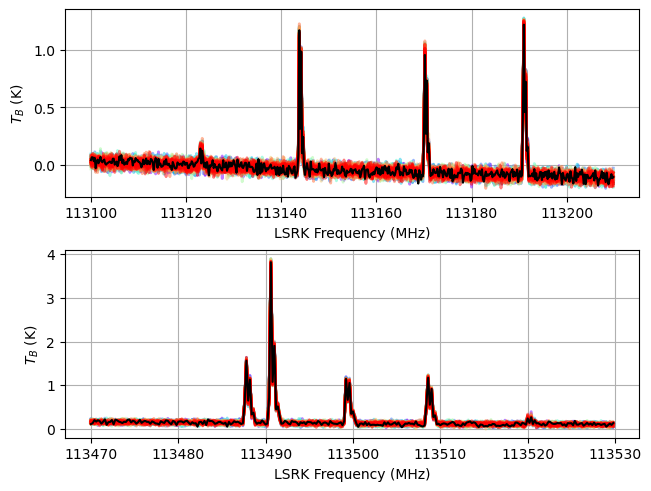

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

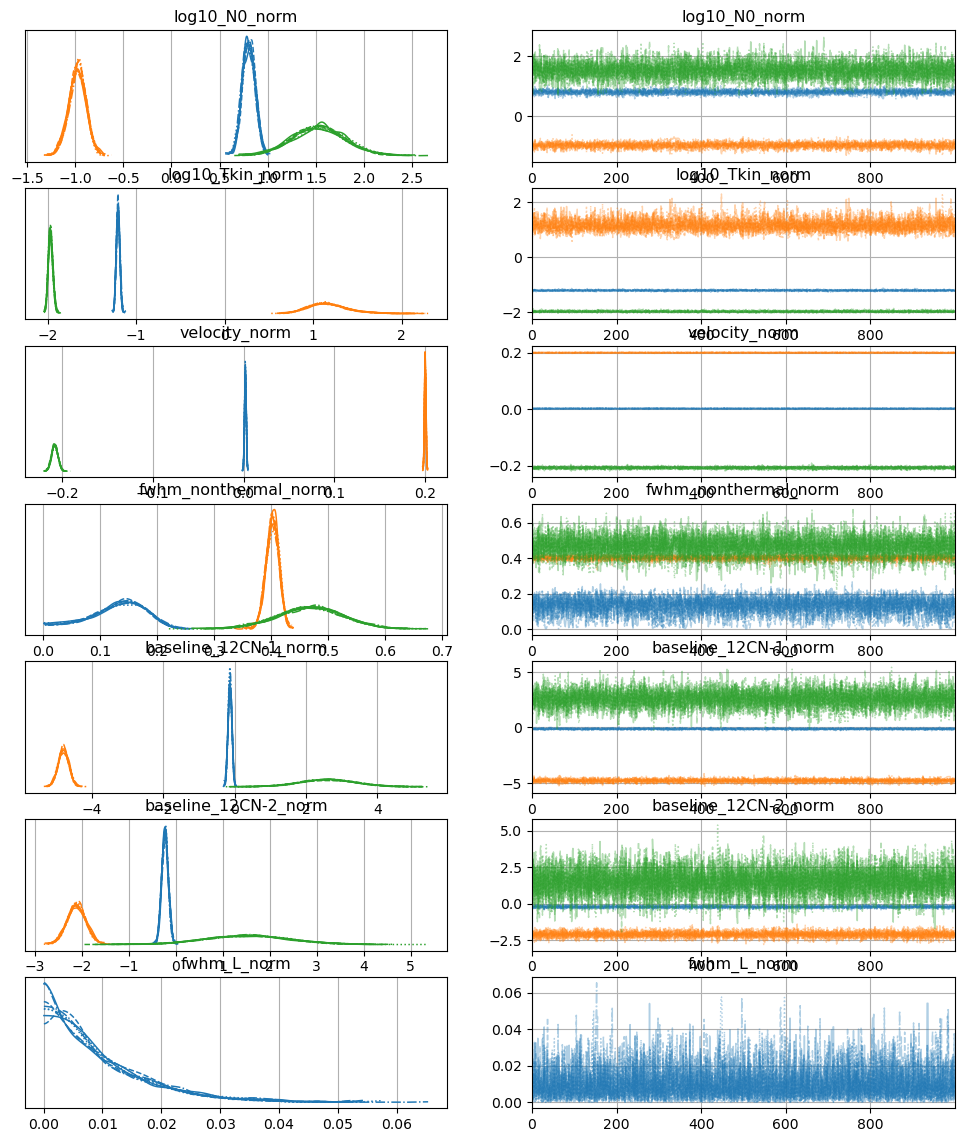

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

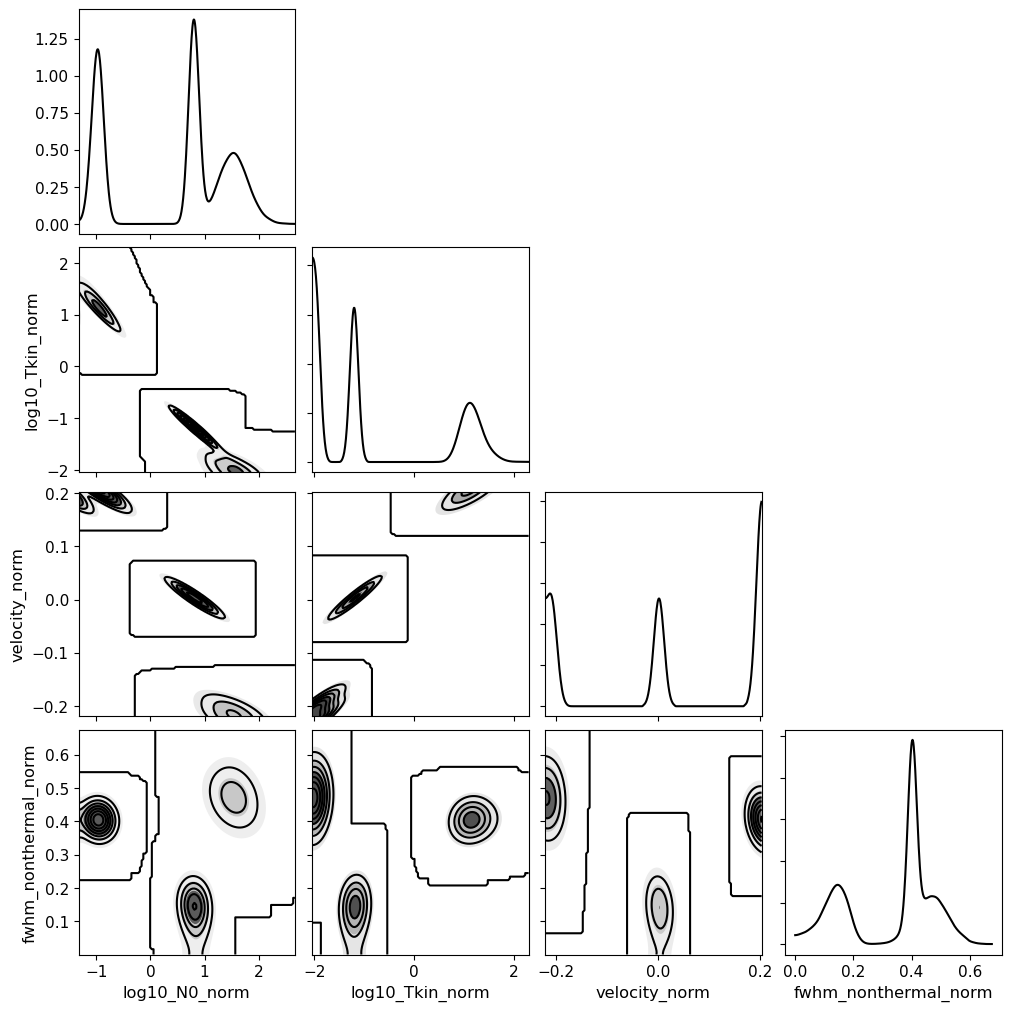

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

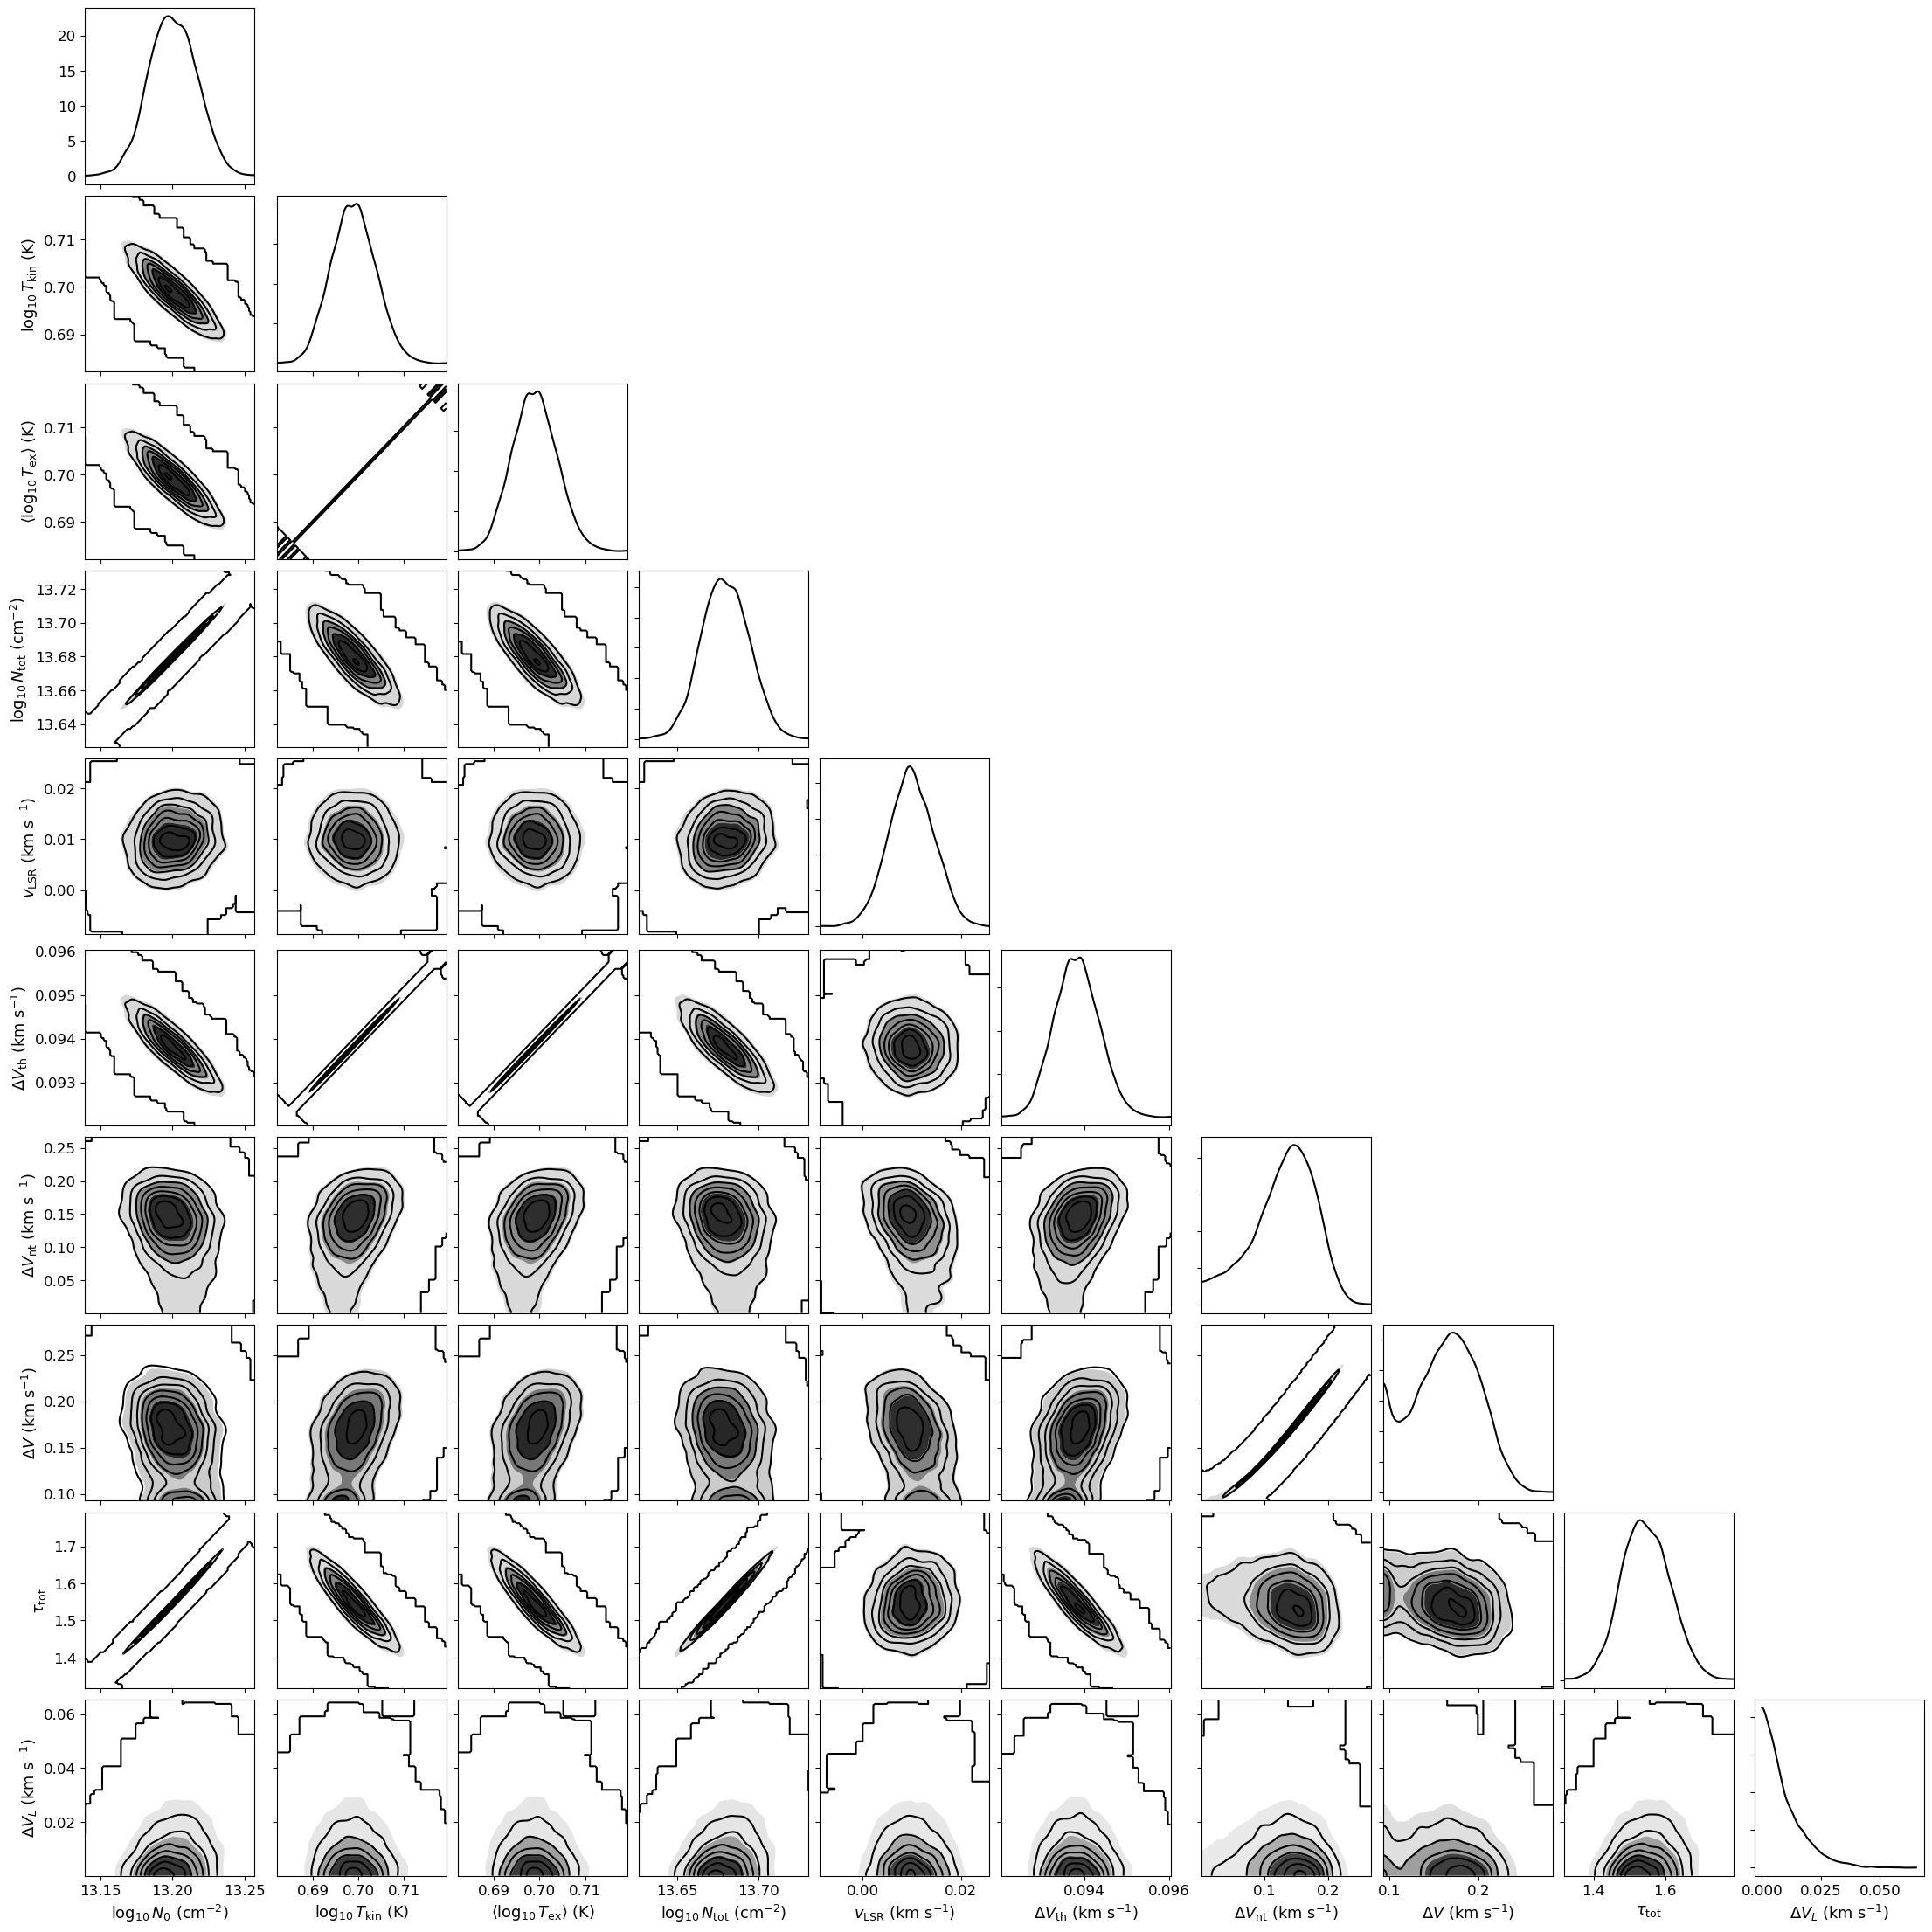

In [19]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

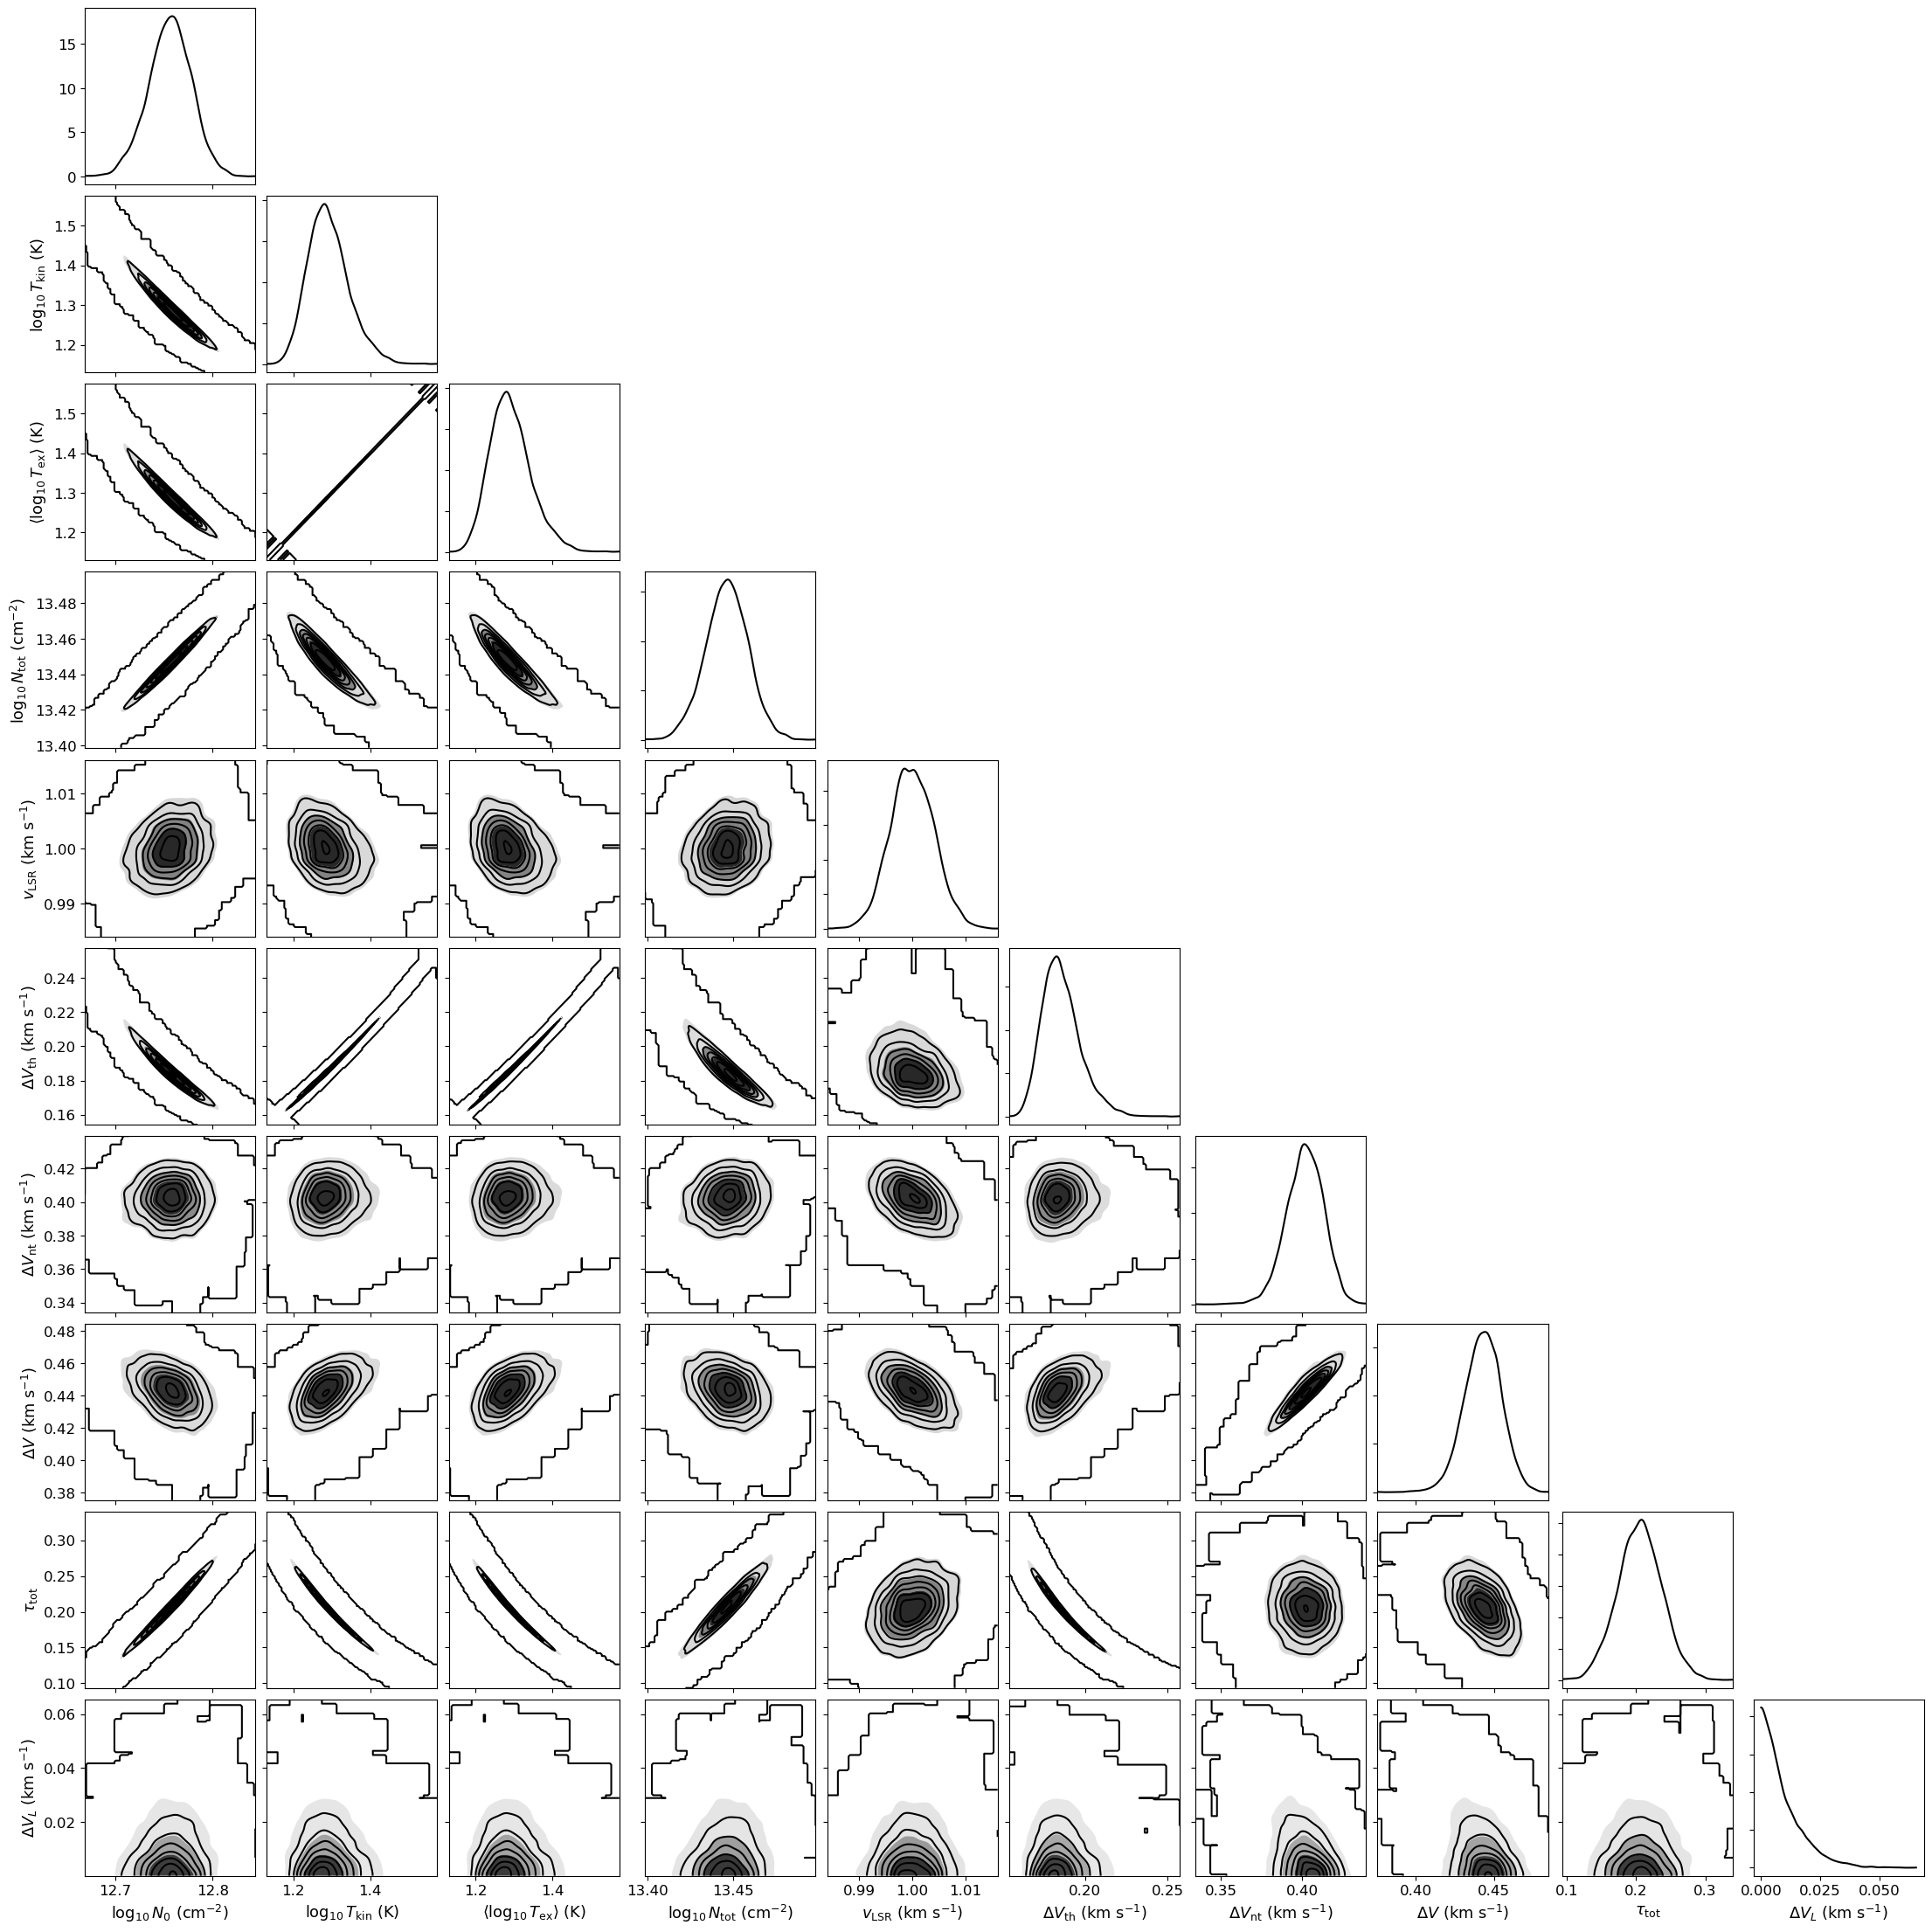

In [20]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

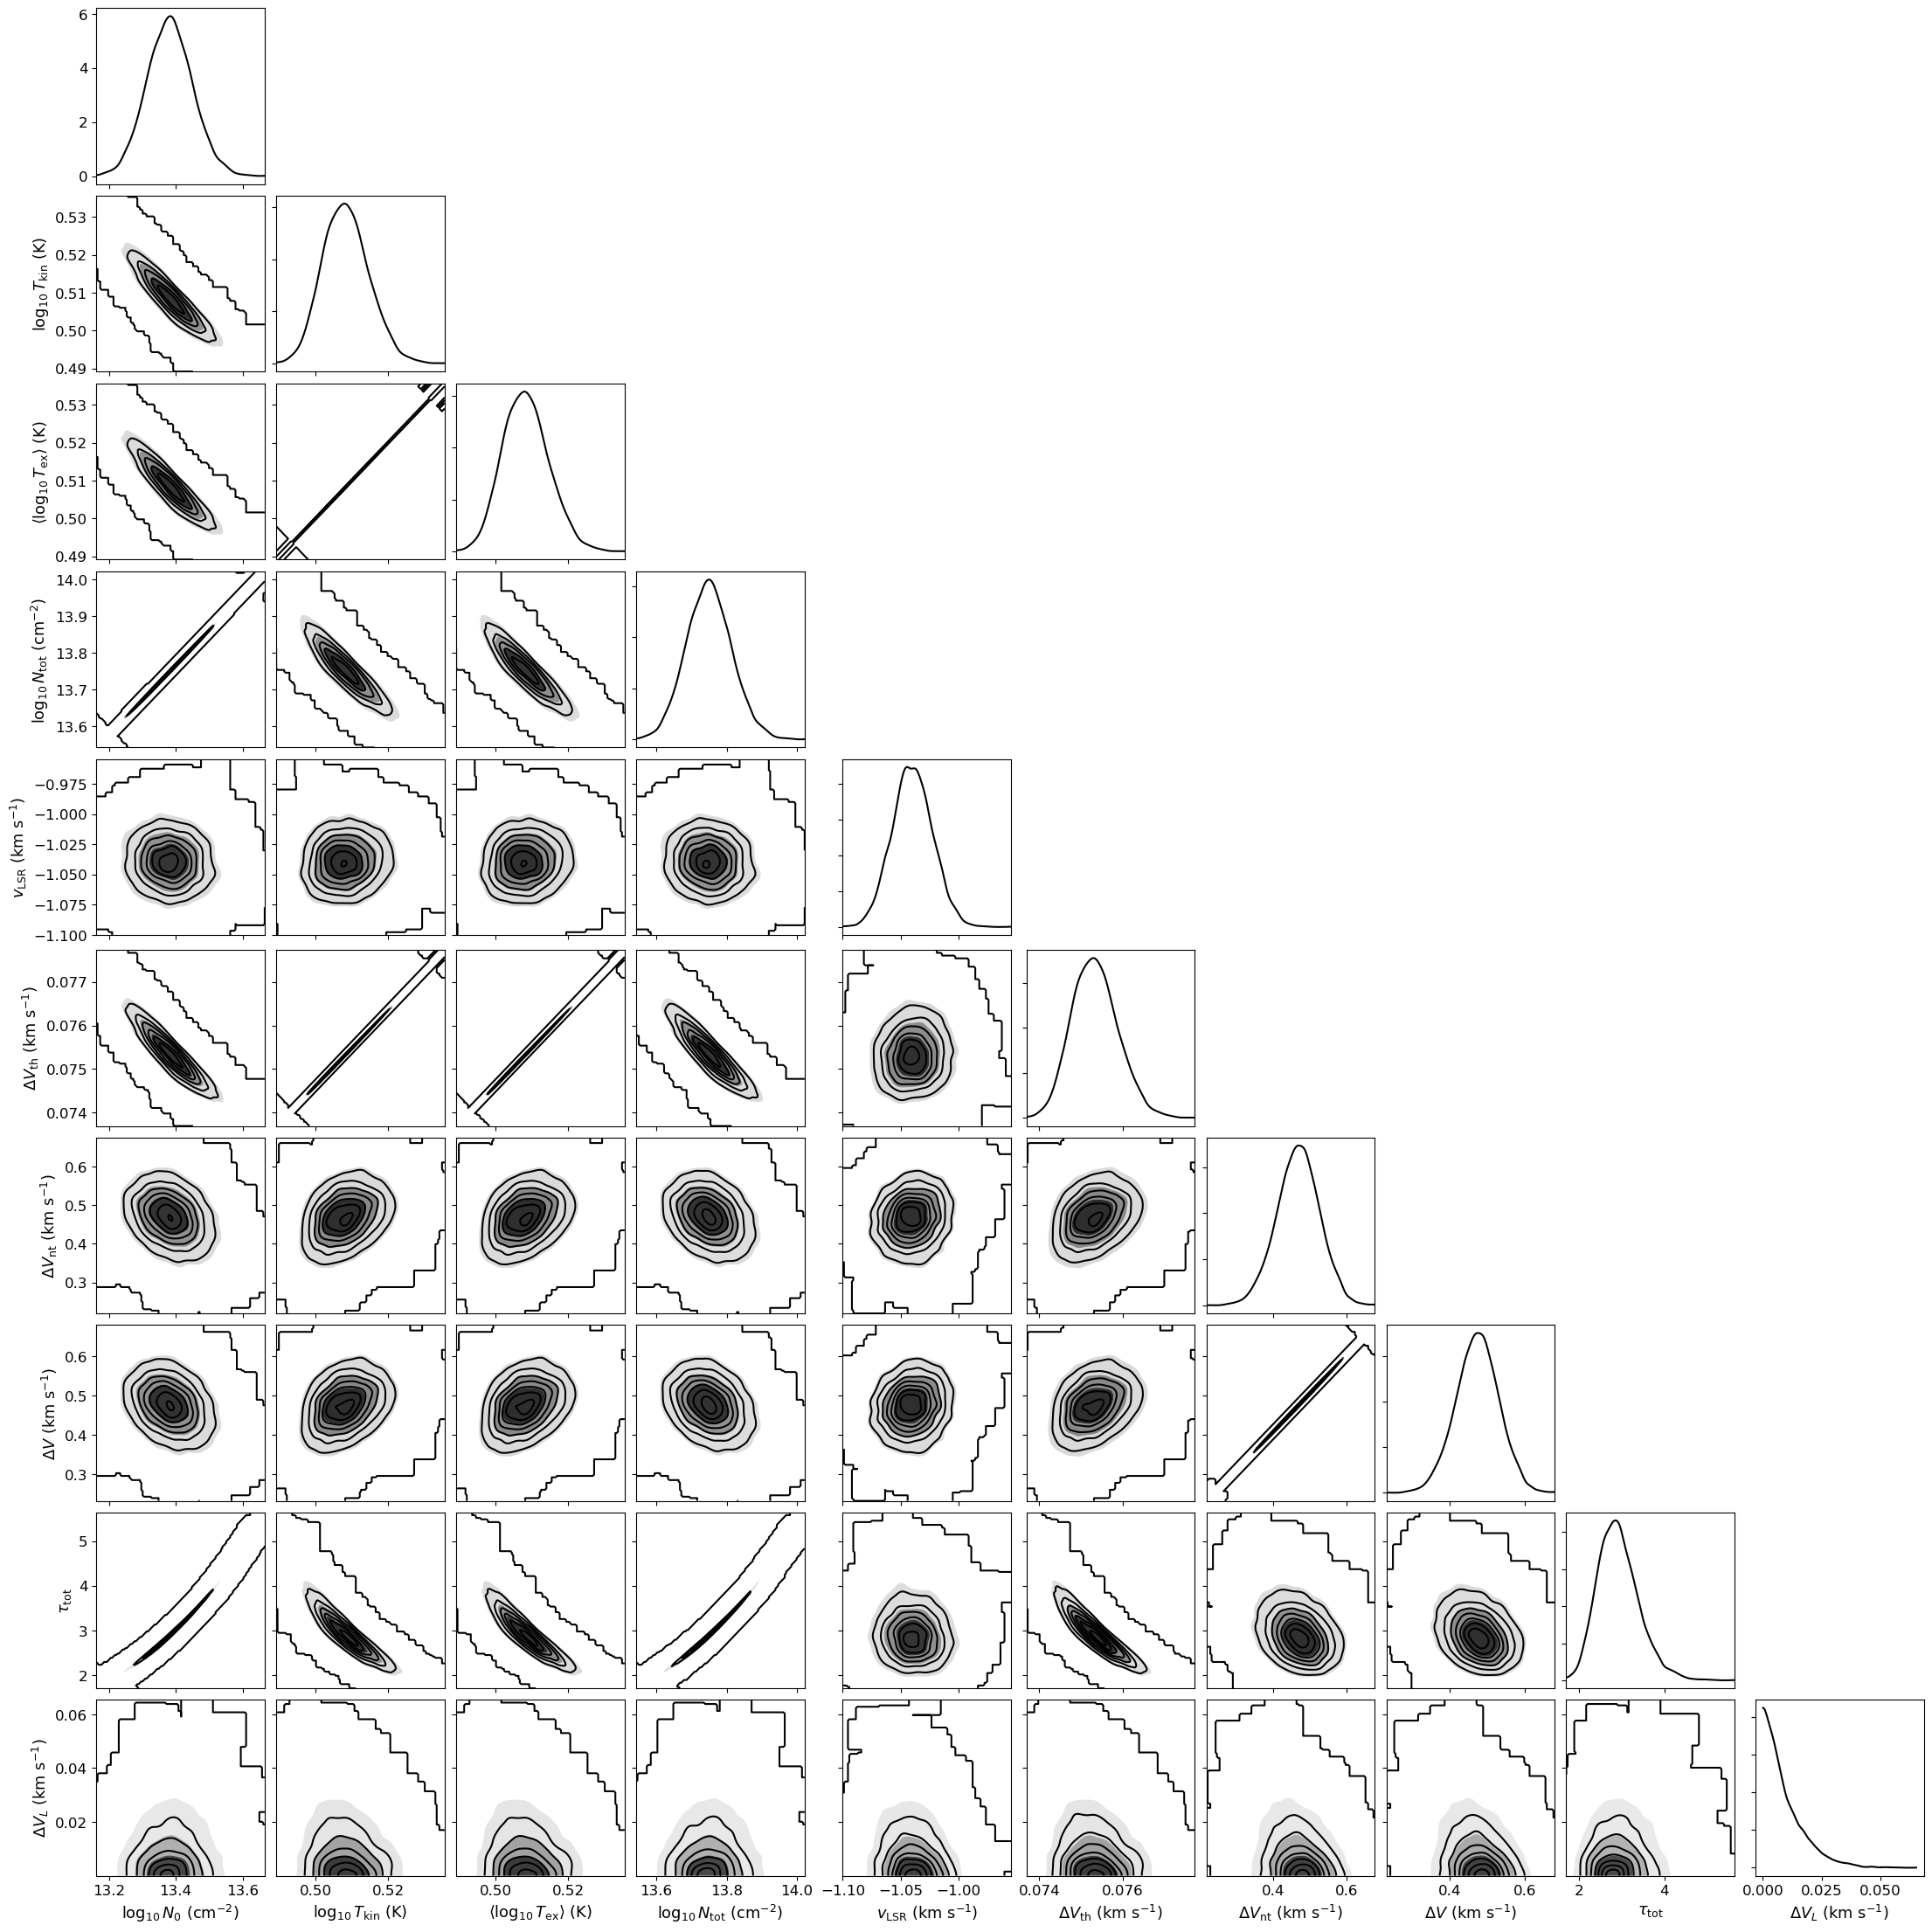

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3371.404815093833


mean     sd  hdi_16%  hdi_84%
log10_N0[0]                       13.200  0.017   13.184   13.217
log10_N0[1]                       12.756  0.022   12.735   12.778
log10_N0[2]                       13.383  0.068   13.318   13.453
log10_Tkin[0]                      0.699  0.005    0.694    0.704
log10_Tkin[1]                      1.292  0.054    1.232    1.334
log10_Tkin[2]                      0.508  0.006    0.501    0.514
log10_Tex_mean[0]                  0.699  0.005    0.694    0.704
log10_Tex_mean[1]                  1.292  0.054    1.232    1.334
log10_Tex_mean[2]                  0.508  0.006    0.501    0.514
Tex[113123.3687, 0]                5.000  0.056    4.943    5.055
Tex[113123.3687, 1]               19.735  2.576   16.791   21.274
Tex[113123.3687, 2]                3.224  0.047    3.172    3.265
Tex[113144.19, 0]                  5.000  0.056    4.943    5.055
Tex[113144.19, 1]                 19.735  2.576   16.791   21.274
Tex[113144.19, 2]                  3.224  0.047    3.172    3.265
Tex[113170.535, 0]                 5.000  0.056    4.943    5.055
Tex[113170.535, 1]                19.735  2.576   16.791   21.274
Tex[113170.535, 2]                 3.224  0.047    3.172    3.265
Tex[113191.325, 0]                 5.000  0.056    4.943    5.055
Tex[113191.325, 1]                19.735  2.576   16.791   21.274
Tex[113191.325, 2]                 3.224  0.047    3.172    3.265
Tex[113488.142, 0]                 5.000  0.056    4.943    5.055
Tex[113488.142, 1]                19.735  2.576   16.791   21.274
Tex[113488.142, 2]                 3.224  0.047    3.172    3.265
Tex[113490.985, 0]                 5.000  0.056    4.943    5.055
Tex[113490.985, 1]                19.735  2.576   16.791   21.274
Tex[113490.985, 2]                 3.224  0.047    3.172    3.265
Tex[113499.643, 0]                 5.000  0.056    4.943    5.055
Tex[113499.643, 1]                19.735  2.576   16.791   21.274
Tex[113499.643, 2]                 3.224  0.047    3.172    3.265
Tex[113508.934, 0]                 5.000  0.056    4.943    5.055
Tex[113508.934, 1]                19.735  2.576   16.791   21.274
Tex[113508.934, 2]                 3.224  0.047    3.172    3.265
Tex[113520.4215, 0]                5.000  0.056    4.943    5.055
Tex[113520.4215, 1]               19.735  2.576   16.791   21.274
Tex[113520.4215, 2]                3.224  0.047    3.172    3.265
log_boltz_factor[113123.3687, 0]  -1.086  0.012   -1.098   -1.074
log_boltz_factor[113123.3687, 1]  -0.279  0.034   -0.315   -0.248
log_boltz_factor[113123.3687, 2]  -1.684  0.025   -1.711   -1.663
log_boltz_factor[113144.19, 0]    -1.086  0.012   -1.099   -1.074
log_boltz_factor[113144.19, 1]    -0.279  0.034   -0.315   -0.248
log_boltz_factor[113144.19, 2]    -1.684  0.025   -1.712   -1.663
log_boltz_factor[113170.535, 0]   -1.086  0.012   -1.099   -1.074
log_boltz_factor[113170.535, 1]   -0.280  0.034   -0.315   -0.248
log_boltz_factor[113170.535, 2]   -1.685  0.025   -1.712   -1.664
log_boltz_factor[113191.325, 0]   -1.087  0.012   -1.099   -1.075
log_boltz_factor[113191.325, 1]   -0.280  0.034   -0.315   -0.248
log_boltz_factor[113191.325, 2]   -1.685  0.025   -1.712   -1.664
log_boltz_factor[113488.142, 0]   -1.089  0.012   -1.102   -1.077
log_boltz_factor[113488.142, 1]   -0.280  0.034   -0.316   -0.249
log_boltz_factor[113488.142, 2]   -1.690  0.025   -1.717   -1.668
log_boltz_factor[113490.985, 0]   -1.089  0.012   -1.102   -1.077
log_boltz_factor[113490.985, 1]   -0.280  0.034   -0.316   -0.249
log_boltz_factor[113490.985, 2]   -1.690  0.025   -1.717   -1.668
log_boltz_factor[113499.643, 0]   -1.090  0.012   -1.102   -1.078
log_boltz_factor[113499.643, 1]   -0.280  0.034   -0.316   -0.249
log_boltz_factor[113499.643, 2]   -1.690  0.025   -1.717   -1.668
log_boltz_factor[113508.934, 0]   -1.090  0.012   -1.102   -1.078
log_boltz_factor[113508.934, 1]   -0.280  0.034   -0.316   -0.249
log_boltz_factor[113508.934, 2]   -1.690  0.025   -1.717   -1.669
log_boltz_

In [23]:
print(sim_params)
print(derived_params)

{'log10_N0': [13.5, 13.2, 12.8], 'log10_Tkin': [0.5, 0.7, 1.2], 'fwhm_nonthermal': [0.5, 0.2, 0.4], 'velocity': [-1.0, 0.0, 1.0], 'fwhm_L': 0.0, 'baseline_12CN-1_norm': [-2.0, -5.0, 8.0], 'baseline_12CN-2_norm': [4.0, -2.0, 5.0]}
{'log10_N': array([13.862653  , 13.67989297, 13.47137344]), 'tau_total': array([3.81440542, 1.54223052, 0.26939305])}
